In [2]:
from importLibrary import *
import ClassificationModel as CM

In [3]:
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
seed = 14
path = "./multiclass_brain_tumor_Dataset"
#"C:/Users/testb/Desktop/jupyter/grapevine_leaf/Grapevine_Leaves_Image_Dataset"
all_data = tf.keras.utils.image_dataset_from_directory(
    path,
    labels='inferred',
    label_mode='categorical',  # etichette one-hot
    image_size=IMG_SIZE,  # ad esempio (224, 224)
    batch_size=None  # nessun batch, ottieni tutte le immagini una per una
)

all_data = all_data.map(lambda x, y: (x / 255.0, y))

# Estrai le immagini e le etichette dal dataset
image_list = []
label_list = []

for image, label in all_data:
    image_list.append(image.numpy())  # Converti l'immagine in NumPy array
    label_list.append(label.numpy())  # Converti l'etichetta in NumPy array

# Converti le liste in array NumPy
image_array = np.array(image_list)
label_array = np.array(label_list)

print(f"image_array.shape: {image_array.shape}")
print(f"label_array.shape: {label_array.shape}")

# Primo split: ottieni training (70%) e temp (30%) per test+validation
X_train, X_temp, y_train, y_temp = train_test_split(
    image_array, label_array, test_size=0.3, stratify=label_array, random_state=seed  # 30% per validation+test
)

# Secondo split: dividi temp in validation (10%) e test (20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.66, stratify=y_temp, random_state=seed  # 2/3 per test, 1/3 per validation
)

# Convertire i dati divisi in tf.data.Dataset
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))#.batch(BATCH_SIZE)
validation_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))#.batch(BATCH_SIZE)

Found 7023 files belonging to 4 classes.
image_array.shape: (7023, 256, 256, 3)
label_array.shape: (7023, 4)


In [4]:
classes = [name for name in os.listdir(path) if os.path.isdir(os.path.join(path, name))]
dict_map = {idx: element for idx, element in enumerate(classes)}

# a = [0,1,2,1,2,3,1]
# mapped_elements = list(map(lambda x: dict_map[x], a)) <- how to convert keys list to the element name list

4916
(256, 256, 3)
tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)


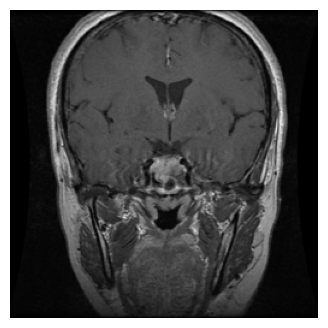

In [5]:
print(train_data.cardinality().numpy()) #num BATCH
for image_batch, labels_batch in train_data:
    print(image_batch.shape)
    print(labels_batch) # contiene one-hot delle classi
    break

img = image_batch[:,:,:].numpy() #.astype(np.uint8)
# Converti l'immagine da BGR a RGB (OpenCV usa BGR per default)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Crea una figura e un'asse
plt.figure(figsize=(4, 4))  # Puoi regolare le dimensioni della figura
plt.imshow(img)  # Mostra l'immagine
plt.axis('off')  # Disabilita gli assi
plt.show()  # Mostra la figura


In [6]:
# Define a function for data augmentation
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)  # Randomly flip the image
    # image = tf.image.random_brightness(image, max_delta=0.1)  # Randomly change brightness
    # image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Randomly adjust contrast
    return image, label

def random_rotate_image(image, label):
    # Scegliamo casualmente tra 1 (90 gradi), 2 (180 gradi) e 3 (270 gradi)
    k = np.random.choice([1, 2, 3])
    return tf.image.rot90(image, k=k), label

# Apply the augmentation function
augmented_data = train_data.map(random_rotate_image)

4916
(256, 256, 3)


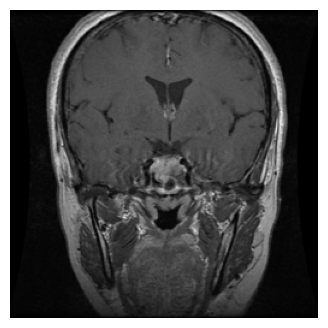

In [7]:
# Converte il dataset in un iteratore numpy
augmented_image, augmented_label = [], []
for images, labels in train_data.as_numpy_iterator():
    augmented_image.append(images)
    augmented_label.append(labels)
    
print(len(augmented_image))
print(augmented_image[0].shape)

img = augmented_image[0]#.astype(np.uint8)
# Converti l'immagine da BGR a RGB (OpenCV usa BGR per default)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Crea una figura e un'asse
plt.figure(figsize=(4, 4))  # Puoi regolare le dimensioni della figura
plt.imshow(img)  # Mostra l'immagine
plt.axis('off')  # Disabilita gli assi
plt.show()  # Mostra la figura

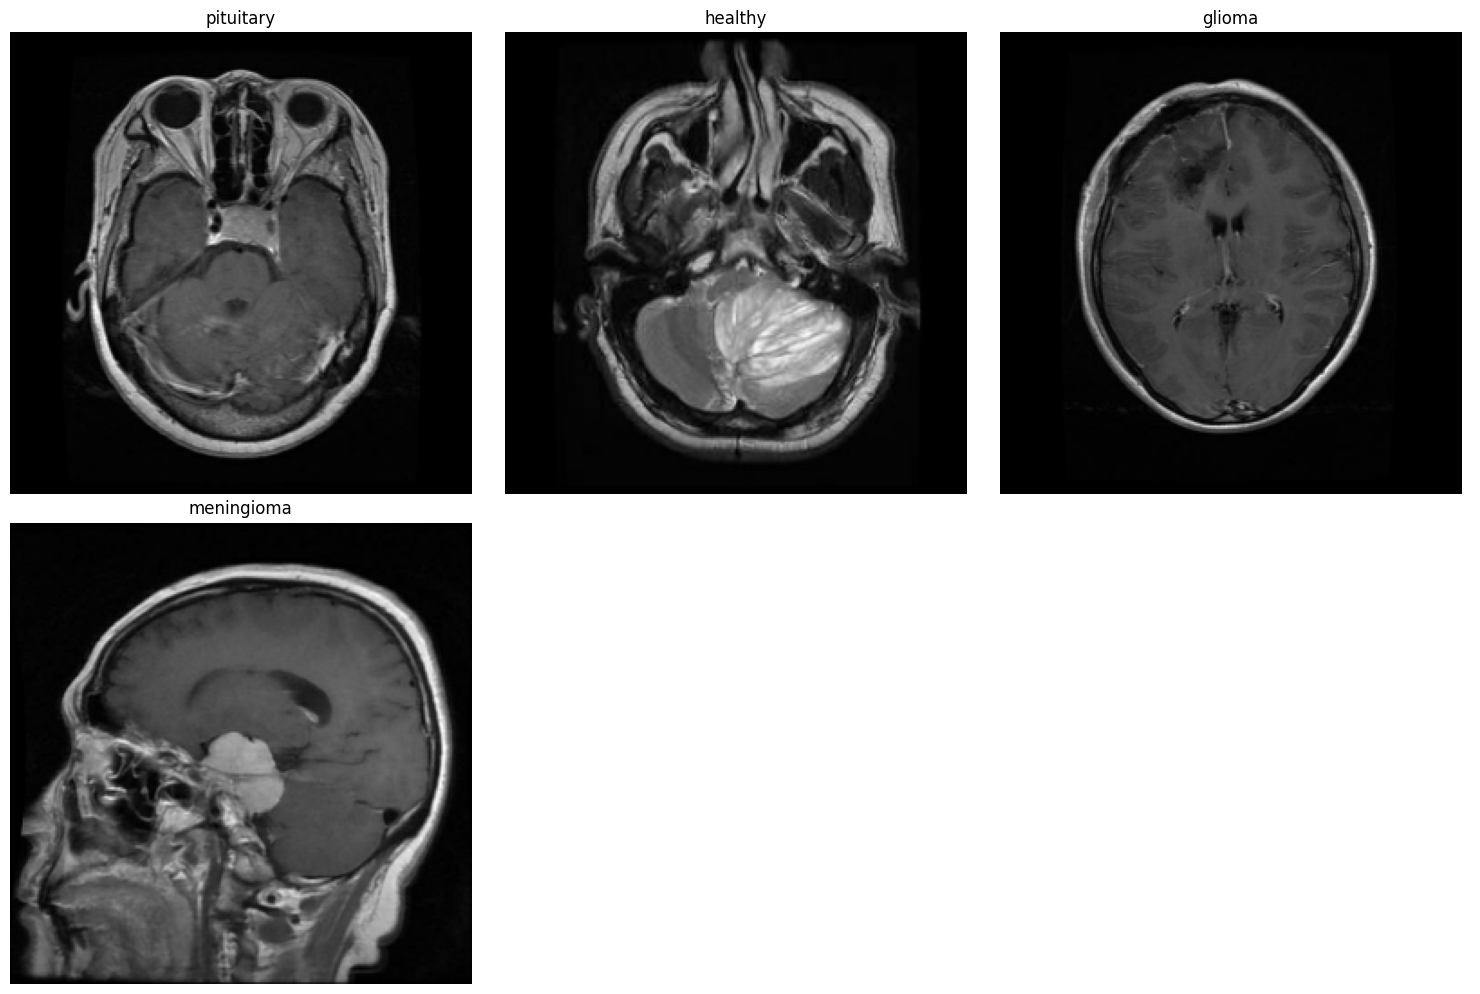

The total number of images in the Training Set is: 4916
The elements in each class are: [[1135. 1400. 1151. 1230.]]


In [8]:
combined_data = train_data

## scommentare se voglio unire anche augmented data al training set ##
# Combiniamo i due dataset (originale e aumentato)
# combined_data = train_data.concatenate(augmented_data)

# Optional: Shuffling e batching del nuovo dataset esteso
combined_data = combined_data.shuffle(buffer_size=1024).batch(BATCH_SIZE)
size =0
num_class = len(classes)
num_class_elem = np.zeros((1,num_class))
IMG = []
LABEL_IMG = []
for img,l in combined_data:
    size += img.shape[0] #sum over the number of element in each batchs
    num_class_elem += np.sum(l, axis=0) 

    for index, label in enumerate(l):
        idx = np.argmax(label)
        if idx not in LABEL_IMG:
            IMG.append(img[index])
            LABEL_IMG.append(idx)
        if len(LABEL_IMG)==num_class:
            break
    

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i in range(num_class):
    ax = axs[i // 3, i % 3]
    ax.imshow(IMG[i])
    ax.axis('off')
    ax.set_title(dict_map[LABEL_IMG[i]])
ax = axs[1,1]
ax.axis('off')
ax = axs[1,2]
ax.axis('off')
plt.tight_layout()
plt.show()

print(f"The total number of images in the Training Set is: {size}")
print(f"The elements in each class are: {num_class_elem}")

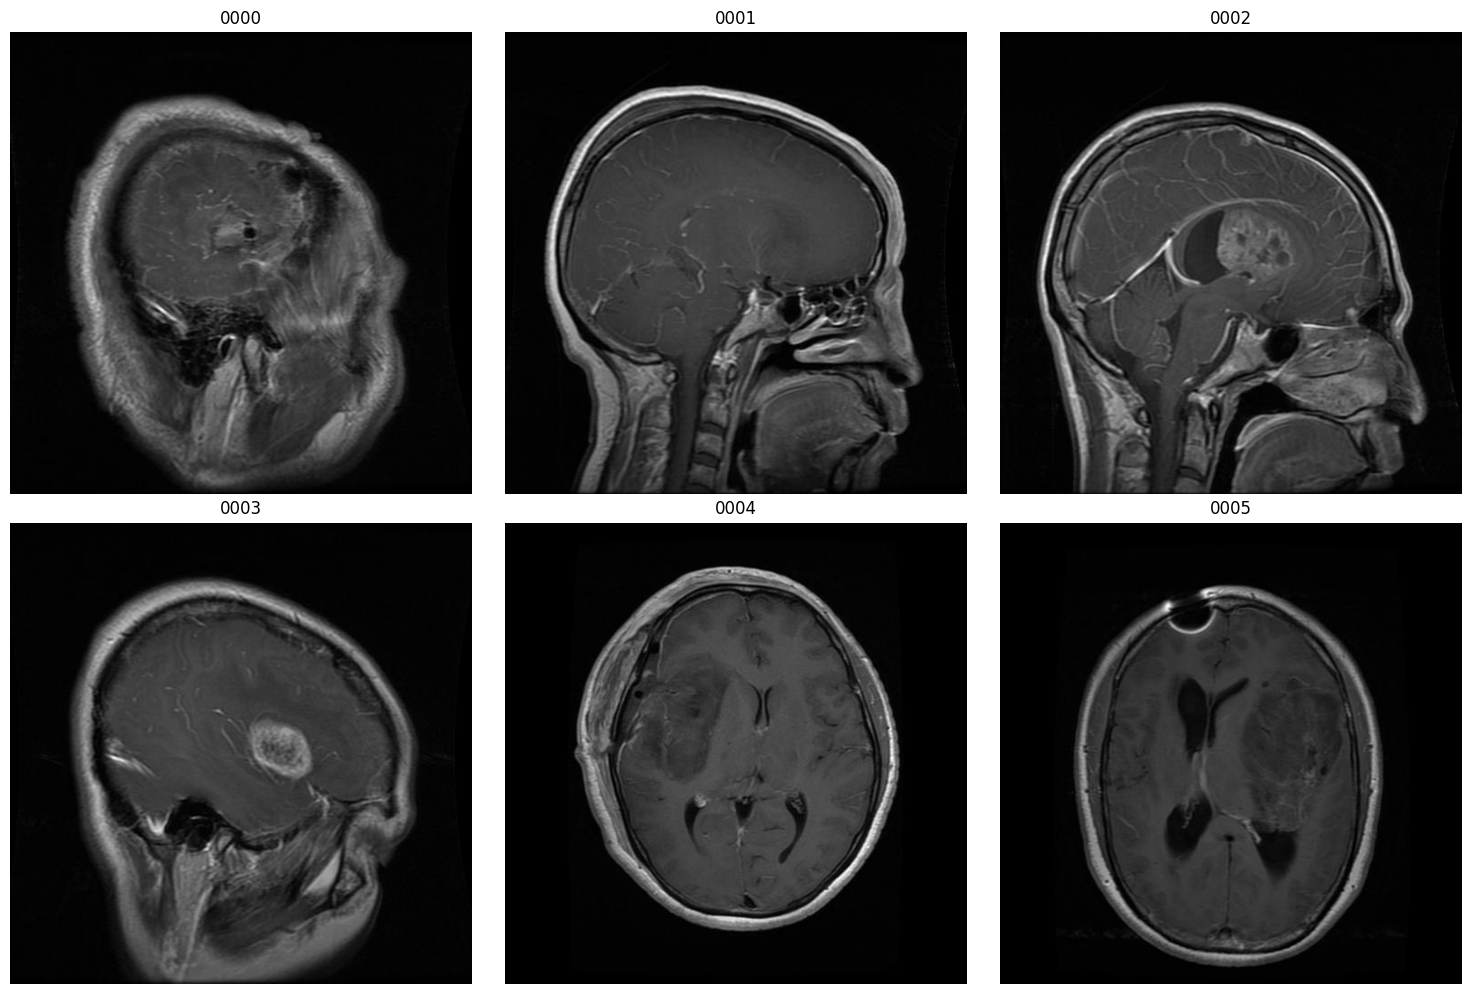

In [9]:
# Path to the directory containing images
PathToInspect = path + "/" + classes[0]
# Get a list of all image file names in the directory
image_files = [f for f in os.listdir(PathToInspect) if os.path.isfile(os.path.join(PathToInspect, f))]
# Display the first 6 images with their labels
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i in range(6):
    # Get the image file name and its label
    image_file = image_files[i]
    label = image_file.split('.')[0]

    # Load and display the image
    img_path = os.path.join(PathToInspect, image_file)
    img = mpimg.imread(img_path)
    ax = axs[i // 3, i % 3]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(label)

plt.tight_layout()
plt.show()

In [10]:
num_classes = y_train.shape[1]
#n= "resNet_fineTuned_"
n = "VGG19_finetuned_"
if n=="resNet_fineTuned_":
    model = CM.GenerateResModel(num_classes)
elif n=="CNN_":
    model = CM.GenerateCNN(num_classes)
elif n=="VGG16_finetuned_":
    model = CM.GenerateVGG16Model(num_classes)  
elif n=="VGG19_finetuned_":
    model = CM.GenerateVGG19Model(num_classes)  
else:
    print("not implemented")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,86

 Total params: 28,453,336 (108.54 MB)

 Trainable params: 8,428,080 (32.15 MB)

 Non-trainable params: 20,025,256 (76.39 MB)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

# Imposta il callback di Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',        # Metric da monitorare (ad esempio la perdita sul validation set)
    patience=5,                # Numero di epoche di pazienza (ad esempio, 5)
    restore_best_weights=True  # Ripristina i pesi con le migliori prestazioni sul validation set
)

def TrainModel(model: Model, alpha: float = 0.0001, epochs: int = 20):
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=alpha), metrics=['categorical_accuracy'])
    #train_d = train_data.batch(BATCH_SIZE)
    
    history = model.fit(
        combined_data,
        epochs=epochs,
        verbose=1,
        validation_data=validation_data,  # Batch di validazione separato con dimensione diversa
        #callbacks=[early_stopping]
    )
    return history

Use the single long training

In [39]:
history = TrainModel(model, alpha=0.0001, epochs=20)

Epoch 1/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 1527s 10s/step - categorical_accuracy: 0.4595 - loss: 1.2143 - val_categorical_accuracy: 0.7640 - val_loss: 0.6280
Epoch 2/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 1153s 8s/step - categorical_accuracy: 0.7021 - loss: 0.7790 - val_categorical_accuracy: 0.7947 - val_loss: 0.5148
Epoch 3/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 985s 6s/step - categorical_accuracy: 0.7601 - loss: 0.6448 - val_categorical_accuracy: 0.8170 - val_loss: 0.4369
Epoch 4/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 1004s 7s/step - categorical_accuracy: 0.8050 - loss: 0.5482 - val_categorical_accuracy: 0.8282 - val_loss: 0.3903
Epoch 5/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 909s 6s/step - categorical_accuracy: 0.8192 - loss: 0.4893 - val_categorical_accuracy: 0.8631 - val_loss: 0.3362
Epoch 6/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 1720s 11s/step - categorical_accuracy: 0.8427 - loss: 0.4354 - val_categorical_accuracy: 0.8799 - val_loss: 0.3086
Epoch 7/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 2347s 15s/step - categorical_accurac

In [ ]:
## usare se si vuole doppio training:
## prima training solo output network e la pretrained all freezed
## secondo training in cui sblocco gli ultimi layer della pretrained

# model.trainable = False
# for layer in model.layers[-20:]:  # Freeze all layers except the last 4
#         layer.trainable = True

In [ ]:
## Uncomment and save the model
num = 20
model.save('./'+ n + str(num) +'.keras')

If you want to split the training in shorter training and save the models - aspecially without GPU

In [ ]:
# H = []
# for i in range(1,3):
#     print("Training ... N° " + str(i))
#     if (i!=1):
#         model = tf.keras.models.load_model('./'+n+str((i-1)*20)+'_.keras')
#     history = TrainModel(model, alpha=0.0001, epochs=20)
#     H.append(history)
#     name = n+str(i*20)+'_'
#     model.save('./'+name+'.keras')
    

load model with "idx_model" number of epochs

In [ ]:
## Load "VGG19_finetuned_" model previously saved
idx_model = 20
name = "VGG19_finetuned_"
model = tf.keras.models.load_model('./'+name+str(idx_model)+'.keras')

In [41]:
def PlotHistory(history) -> None:
    # Plot training & validation accuracy values
    plt.plot(history.history['categorical_accuracy'], label='train accuracy') #categorical_accuracy
    # plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'], label='train loss')
    # plt.plot(history.history['val_loss'], label='val loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

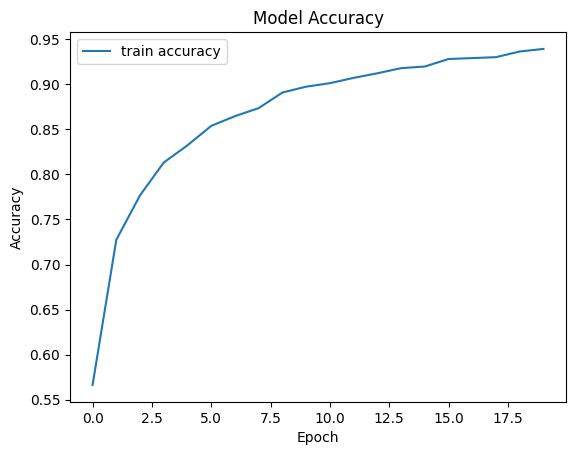

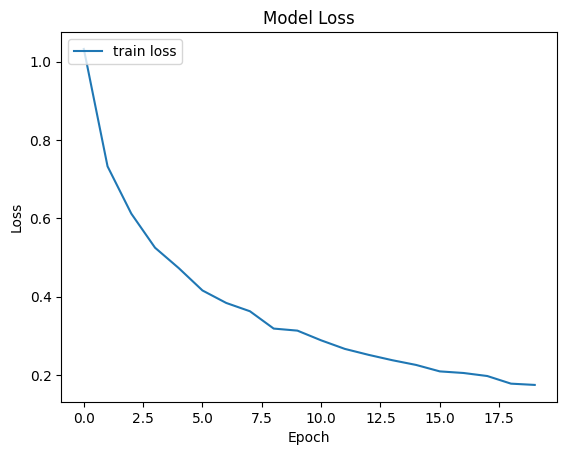

In [42]:
PlotHistory(history)

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

def PlotMetrics(max_indices_val, max_indices_pred):
    # Create the confusion matrix
    nn_cm = confusion_matrix(max_indices_val, max_indices_pred)
    accuracy = accuracy_score(max_indices_val, max_indices_pred)
    precision = precision_score(max_indices_val, max_indices_pred, average='macro')
    recall = recall_score(max_indices_val, max_indices_pred, average='macro')
    f1 = f1_score(max_indices_val, max_indices_pred, average='macro')

    print(nn_cm)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

Confusion matrix on the Training set

In [ ]:
y_pred = model.predict(X_train)
# print(y_pred)
# print(y_test)
max_indices_pred = np.argmax(y_pred, axis=1) #prediction as class number
max_indices_val = np.argmax(y_train, axis=1) #prediction as class number
PlotMetrics(max_indices_val, max_indices_pred)

Confusion matrix on the Test set

In [16]:
y_pred = model.predict(X_test)
# print(y_pred)
# print(y_test)
max_indices_pred = np.argmax(y_pred, axis=1) #prediction as class number
max_indices_val = np.argmax(y_test, axis=1) #prediction as class number


PlotMetrics(max_indices_val, max_indices_pred)

44/44 ━━━━━━━━━━━━━━━━━━━━ 227s 5s/step
[[299   0  22   0]
 [  0 393   3   0]
 [  4   1 317   4]
 [  0   0   0 348]]
Accuracy: 0.9755571531272466
Precision: 0.9749493893084206
Recall: 0.9740702637289702
F1 Score: 0.9741643882217482
